# Projet : Analyse de la Structure par Terme des Futures

Ce projet vise à analyser et visualiser la structure par terme des contrats futures (futures term structure) afin d’identifier les régimes de contango, de backwardation et de mesurer les déséquilibres relatifs de prix à l’aide d’un Z-score.

À partir d’un ensemble de contrats futures ( déjà enregistrés en csv ) caractérisés par leur date d’échéance et leur prix, le modèle :

1-**Trie et structure la courbe forward dans le temps**

2-**Détecte automatiquement le régime de marché**:
    **Contango : prix croissants avec l’échéance**
    **Backwardation : prix décroissants avec l’échéance**

3-**Visualise graphiquement la courbe forward avec un code couleur intuitif**

4-**Normalise les prix via un Z-score pour détecter les sur/sous-évaluations relatives entre maturités**

In [6]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

In [12]:
df_term=pd.read_csv("ContratCLafter2025.csv")
df_term

,expiry,price
0,2025-06-20,64.58
1,2025-07-22,63.63
2,2025-08-20,62.73
3,2025-09-22,62.03
4,2025-10-21,61.59
...,...,...
123,2035-09-20,59.36
124,2035-10-22,59.30
125,2035-11-19,59.23
126,2035-12-19,59.16


# Code de la classe


In [421]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class FuturesTermStructure:
    def __init__(self, df_term, symbol='ES'):
        """
        df_term : DataFrame avec au minimum ['expiry', 'price']
        symbol : le nom de l'actif
        """
        self.symbol = symbol
        self.df_term = df_term.copy()
        self.df_term['expiry'] = pd.to_datetime(self.df_term['expiry'])
        self.df_term.sort_values('expiry', inplace=True)
        self.df_term.reset_index(drop=True, inplace=True)

    def detect_structure(self):
        """
        Retourne 'contango', 'backwardation' ou 'flat'
        """
        first_price = self.df_term['price'].iloc[0]
        last_price = self.df_term['price'].iloc[-1]

        if last_price > first_price:
            return 'contango'
        elif last_price < first_price:
            return 'backwardation'
        return 'flat'

    def plot_curve(self):
        
        fig = go.Figure()

    # Initialisation des markers
        marker_x = []
        marker_y = []
        marker_color = []

        for i in range(len(self.df_term) - 1):
            
            x0, x1 = self.df_term['expiry'].iloc[i], self.df_term['expiry'].iloc[i+1]
            y0, y1 = self.df_term['price'].iloc[i], self.df_term['price'].iloc[i+1]

        # couleur selon la pente
            if y1 > y0:
                
                fillcolor = 'rgba(0, 150, 255, 0.3)'  # Contango
                linecolor = 'rgba(0, 150, 255, 1)'
                point_color = 'rgb(0, 150, 255)'
            else:
                fillcolor = 'rgba(255, 50, 50, 0.3)'  # Backwardation
                linecolor = 'rgba(255, 50, 50, 1)'
                point_color = 'rgb(255, 50, 50)'

        # Ajouter la zone colorée
            fig.add_trace(go.Scatter(
            x=[x0, x1, x1, x0],
            y=[y0, y1, 1, 1],  # Base à 59 pour le remplissage
            fill='toself',
            fillcolor=fillcolor,
            line=dict(width=0),
            mode='none',
            showlegend=False
        ))

        # Ajouter le segment de ligne
            fig.add_trace(go.Scatter(
            x=[x0, x1],
            y=[y0, y1],
            mode='lines',
            line=dict(color=linecolor, width=2),
            showlegend=False
        ))

        # Markers de début de segment
            marker_x.append(x0)
            marker_y.append(y0)
            marker_color.append(point_color)

    # Dernier point
        marker_x.append(self.df_term['expiry'].iloc[-1])
        marker_y.append(self.df_term['price'].iloc[-1])
        marker_color.append(marker_color[-1])  # même couleur que le dernier segment

    # Trace des points
        fig.add_trace(go.Scatter(
        x=marker_x,
        y=marker_y,
        mode='markers',
        marker=dict(size=5, color=marker_color),
        text=[f"{p:.2f}" for p in marker_y],
        textposition="top center",
        showlegend=False
    ))

    # Définir bornes Y
        # Calcul dynamique sans casser l'axe
        y_min = self.df_term['price'].min() - 1
        y_max = self.df_term['price'].max() + 1

    # inverser si besoin
        if y_min > y_max:
            
            y_min, y_max = y_max, y_min

        fig.update_layout(
        height=600,
        width=1100,
        title=f'Courbe Forward (Contango/Backwardation) - {self.symbol}',
        xaxis_title='Échéance',
        yaxis_title='Prix',
        xaxis=dict(type='date', tickformat="%b\n%Y"),
        yaxis=dict(range=[y_min, y_max]),  # maintenant correctement ordonné
        template='plotly_dark'
)


        return fig




    def compute_zscore(self, window=20, plot=True):
        """
        Calcul du Z-score sur les prix des futures
        """
        price_series = self.df_term['price']
        z = (price_series - price_series.mean()) / price_series.std()
        self.df_term['z_score'] = z

        if plot:
            fig = go.Figure()
            fig.add_trace(go.Bar(
                x=self.df_term['expiry'],
                y=z,
                name='Z-Score',
                marker_color='orange'
            ))
            fig.update_layout(
                height=600,width=1100,
                title=f'Z-Score des Prix - {self.symbol}',
                xaxis_title='Échéance',
                yaxis_title='Z-Score',
                template='plotly_dark'
            )
            return fig

        return self.df_term


# Essai

In [422]:
analyzer = FuturesTermStructure(df_term,symbol='')

In [425]:
analyzer.detect_structure()

'backwardation'

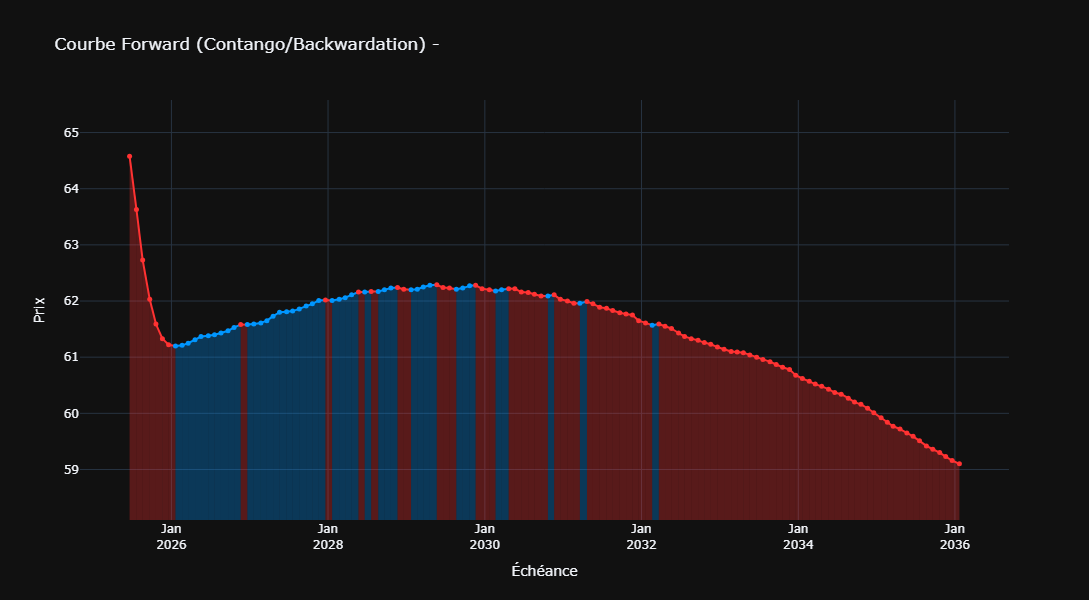

In [427]:
analyzer.plot_curve()

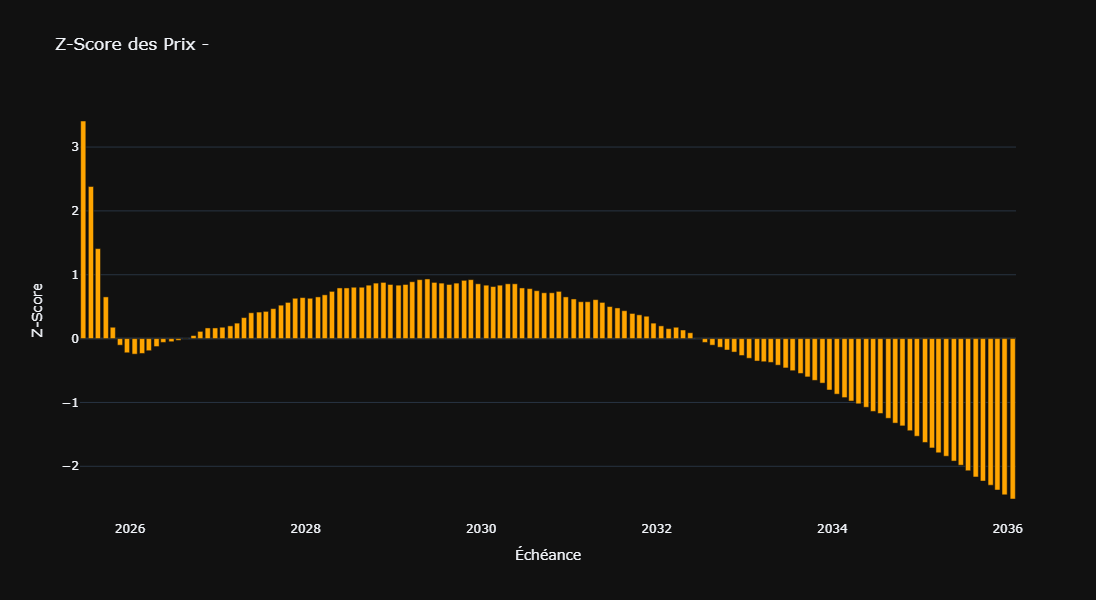

In [433]:
analyzer.compute_zscore(1000)